<a href="https://colab.research.google.com/github/SMAntony/deep-learning-tools/blob/main/Lab3_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import re, string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
dataset_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"

dataset_zipped = tf.keras.utils.get_file(
  "text-collections.zip",
  "http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip",
   extract = True,
   cache_dir = '.',)
   #cache_subdir = '')

# dataset_dir = os.path.join(os.path.dirname(dataset), 'wiki_crop')


212992/203415 [===============================] - 0s 1us/step


In [ ]:
dataset_df = pd.read_csv("/content/datasets/SMSSpamCollection",sep="\t", header=None)
dataset_df.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
  sum(dataset_df[0]=="ham"), sum(dataset_df[0]=="spam")

(4825, 747)

In [ ]:
shuffled_df = dataset_df.sample(frac = 1)
shuffled_df[0] = np.where(shuffled_df[0] == "ham", 0, 1).astype('float32')

shuffled_df

,0,1
5499,0.0,Now get step 2 outta the way. Congrats again.
4201,0.0,I will come tomorrow di
508,0.0,You should know now. So how's anthony. Are you...
3036,0.0,Raji..pls do me a favour. Pls convey my Birthd...
4042,1.0,Please call our customer service representativ...
...,...,...
3957,0.0,Haha... dont be angry with yourself... Take it...
848,0.0,I am in office:)whats the matter..msg me now.i...
5491,0.0,U studying in sch or going home? Anyway i'll b...
3705,0.0,Kent vale lor... Ü wait 4 me there ar?


In [ ]:
train,test,val=np.split(shuffled_df,[int(0.8*len(shuffled_df)), int(0.9*len(shuffled_df))])

In [ ]:
train

,0,1
5499,0.0,Now get step 2 outta the way. Congrats again.
4201,0.0,I will come tomorrow di
508,0.0,You should know now. So how's anthony. Are you...
3036,0.0,Raji..pls do me a favour. Pls convey my Birthd...
4042,1.0,Please call our customer service representativ...
...,...,...
4180,0.0,Can ü send me a copy of da report?
62,0.0,Its a part of checking IQ
1280,0.0,Waiting 4 my tv show 2 start lor... U leh stil...
5339,0.0,You'd like that wouldn't you? Jerk!


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train[1],train[0])).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test[1],test[0])).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices((val[1],val[0])).batch(64)

In [ ]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, ' \d+', ' ')
    return tf.strings.regex_replace(
        stripped_html,
        f'[{re.escape(string.punctuation)}]',
        ''
    )

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)
vectorize_layer.adapt(train_ds.map(lambda x, y: x))

In [ ]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=32,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])



In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 250, 32)           253792    
                                                                 
 bidirectional (Bidirectiona  (None, 250, 64)          16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                        

In [ ]:
history = model.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
70/70 [==============================] - 35s 162ms/step - loss: 0.6669 - accuracy: 0.8629 - val_loss: 0.6257 - val_accuracy: 0.8674
Epoch 2/30
70/70 [==============================] - 6s 87ms/step - loss: 0.5558 - accuracy: 0.8629 - val_loss: 0.4864 - val_accuracy: 0.8674
Epoch 3/30
70/70 [==============================] - 6s 87ms/step - loss: 0.4348 - accuracy: 0.8629 - val_loss: 0.3780 - val_accuracy: 0.8674
Epoch 4/30
70/70 [==============================] - 6s 87ms/step - loss: 0.2962 - accuracy: 0.8629 - val_loss: 0.2429 - val_accuracy: 0.8674
Epoch 5/30
70/70 [==============================] - 8s 116ms/step - loss: 0.1849 - accuracy: 0.9024 - val_loss: 0.1624 - val_accuracy: 0.9588
Epoch 6/30
70/70 [==============================] - 6s 87ms/step - loss: 0.1167 - accuracy: 0.9809 - val_loss: 0.1299 - val_accuracy: 0.9785
Epoch 7/30
70/70 [==============================] - 6s 87ms/step - loss: 0.0773 - accuracy: 0.9872 - val_loss: 0.1135 - val_accuracy: 0.9821
Epoch 8/30

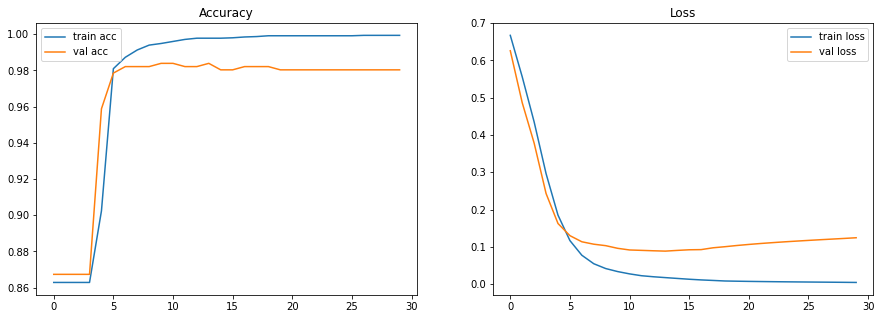

In [ ]:
history = history.history

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Accuracy")
plt.plot(history["accuracy"],label="train acc")
plt.plot(history["val_accuracy"],label="val acc")
plt.legend()

plt.subplot(122)
plt.title("Loss")
plt.plot(history["loss"],label="train loss")
plt.plot(history["val_loss"],label="val loss")
plt.legend()

plt.show()

In [ ]:
loss ,accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

9/9 [==============================] - 0s 23ms/step - loss: 0.1021 - accuracy: 0.9820
Loss:  0.10212253779172897
Accuracy:  0.9820466637611389
